In [ ]:
!pip install importlib-metadata==4.13.0
!pip install dionysus
!pip install gudhi
!pip install networkx
!pip install persim
!pip install xarray
!pip install validclust
!pip install POT==0.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached dionysus-2.0.9.tar.gz (1.7 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for dionysus: filename=dionysus-2.0.9-cp39-cp39-linux_x86_64.whl size=343943 sha256=7163a0572169e3e1936578464b45e377655c43d73821bb3772b156097178f8d1
  Stored in directory: /root/.cache/pip/wheels/f1/2d/23/0540e5b7840f02182e93a3c56a2669646d509eae05afb2c7ac
Successfully built dionysus
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes:

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/NASA")
!ls -ltr

total 14443
-rw------- 1 root root    1667 Oct  5 18:53  zigzagtools.py
-rw------- 1 root root   85452 Oct  5 18:53  zigzag_PD_eps_1.pdf
-rw------- 1 root root       0 Oct  5 18:53  VRrips.pk
-rw------- 1 root root  133051 Oct  5 18:53  PIs_labelled_modulo_month.pdf
-rw------- 1 root root  132779 Oct  5 18:53  PIs_labelled_modulo_month_1.pdf
-rw------- 1 root root  105850 Oct  5 18:53  PIs_labelled_modulo_month_0.pdf
-rw------- 1 root root  127787 Oct  5 18:53  PIs_labelled_1.pdf
-rw------- 1 root root  116243 Oct  5 18:53  PIs_labelled_0.pdf
-rw------- 1 root root  253295 Oct  5 18:53  PClouds.pdf
-rw------- 1 root root 1682280 Oct  5 18:53  Merra_t2m_freudenthal_Oct_2022.ipynb
-rw------- 1 root root  324306 Oct  5 18:53  Merra_t2m_freudenthal.ipynb
-rw------- 1 root root  323836 Oct  5 18:53  MERRA2_t2m_GP_20210201-20210228.nc
-rw------- 1 root root 1690684 Oct  5 18:53  MERRA2_t2m_CONUS_20210201-20210228.nc
-rw------- 1 root root  527019 Oct  5 18:53  MERRA2_t2m_CONUS_20210201-20210

In [ ]:
import numpy as np
import dionysus as d
import matplotlib.pyplot as plt
import time
import sys
import time
import math

In [ ]:
import os
import xarray as xr

In [ ]:
path = os.getcwd()
#%% Parameters 
#nameFolderCloud = path + '/PointCloud/5_Dimensions/datafullpc'  # Example 1 (Dorcas)  (sizeWindow = 10) * It has not any interesting structures
#nameFolderCloud = path + '/PointCloud/FIG8Saved_40/File'  # Example 2  (sizeWindow = 12)
#nameFolderCloud = path + '/../Example_POINT_CLOUD/PointCloud/FIG8Saved_60/File'  # Example 3  (sizeWindow = 12)
#scaleParameter = 1.0 # [Example 2 and 3] Maximum Scale Parameter for Filtration (Depends on distance between points)
#scaleParameter = 9.0 # [Example 1] Maximum Scale Parameter for Filtration (Depends on distance between points)
maxDimHoles = 2 # Maximum Dimension of Holes (It means.. 0 and 1)
sizeWindow = 28 # [Example 2 and 3] Number of Point-Clouds (i.e. timestamps) 
#sizeWindow = 10 # [Example 1] Number of Point-Clouds (i.e. timestamps) 

In [ ]:
fname = 'MERRA2_t2m_GP_20210201-20210228.nc'
ds = xr.open_dataset(fname)
data = ds['t2m'].squeeze()

print (np.array(data[0,:, :]))

[[288.49606323 289.03155518 287.08218384 ... 282.00143433 282.7444458
  283.34893799]
 [286.56442261 286.54849243 284.95831299 ... 281.21334839 281.68276978
  281.62319946]
 [283.40982056 283.60250854 282.26071167 ... 280.56246948 280.49966431
  280.5128479 ]
 ...
 [272.62832642 272.45513916 272.47271729 ... 265.21435547 265.72332764
  265.02468872]
 [272.60656738 272.92019653 272.78347778 ... 264.9175415  265.2008667
  264.56951904]
 [275.76651001 275.35919189 274.49002075 ... 264.76290894 264.65261841
  263.64828491]]


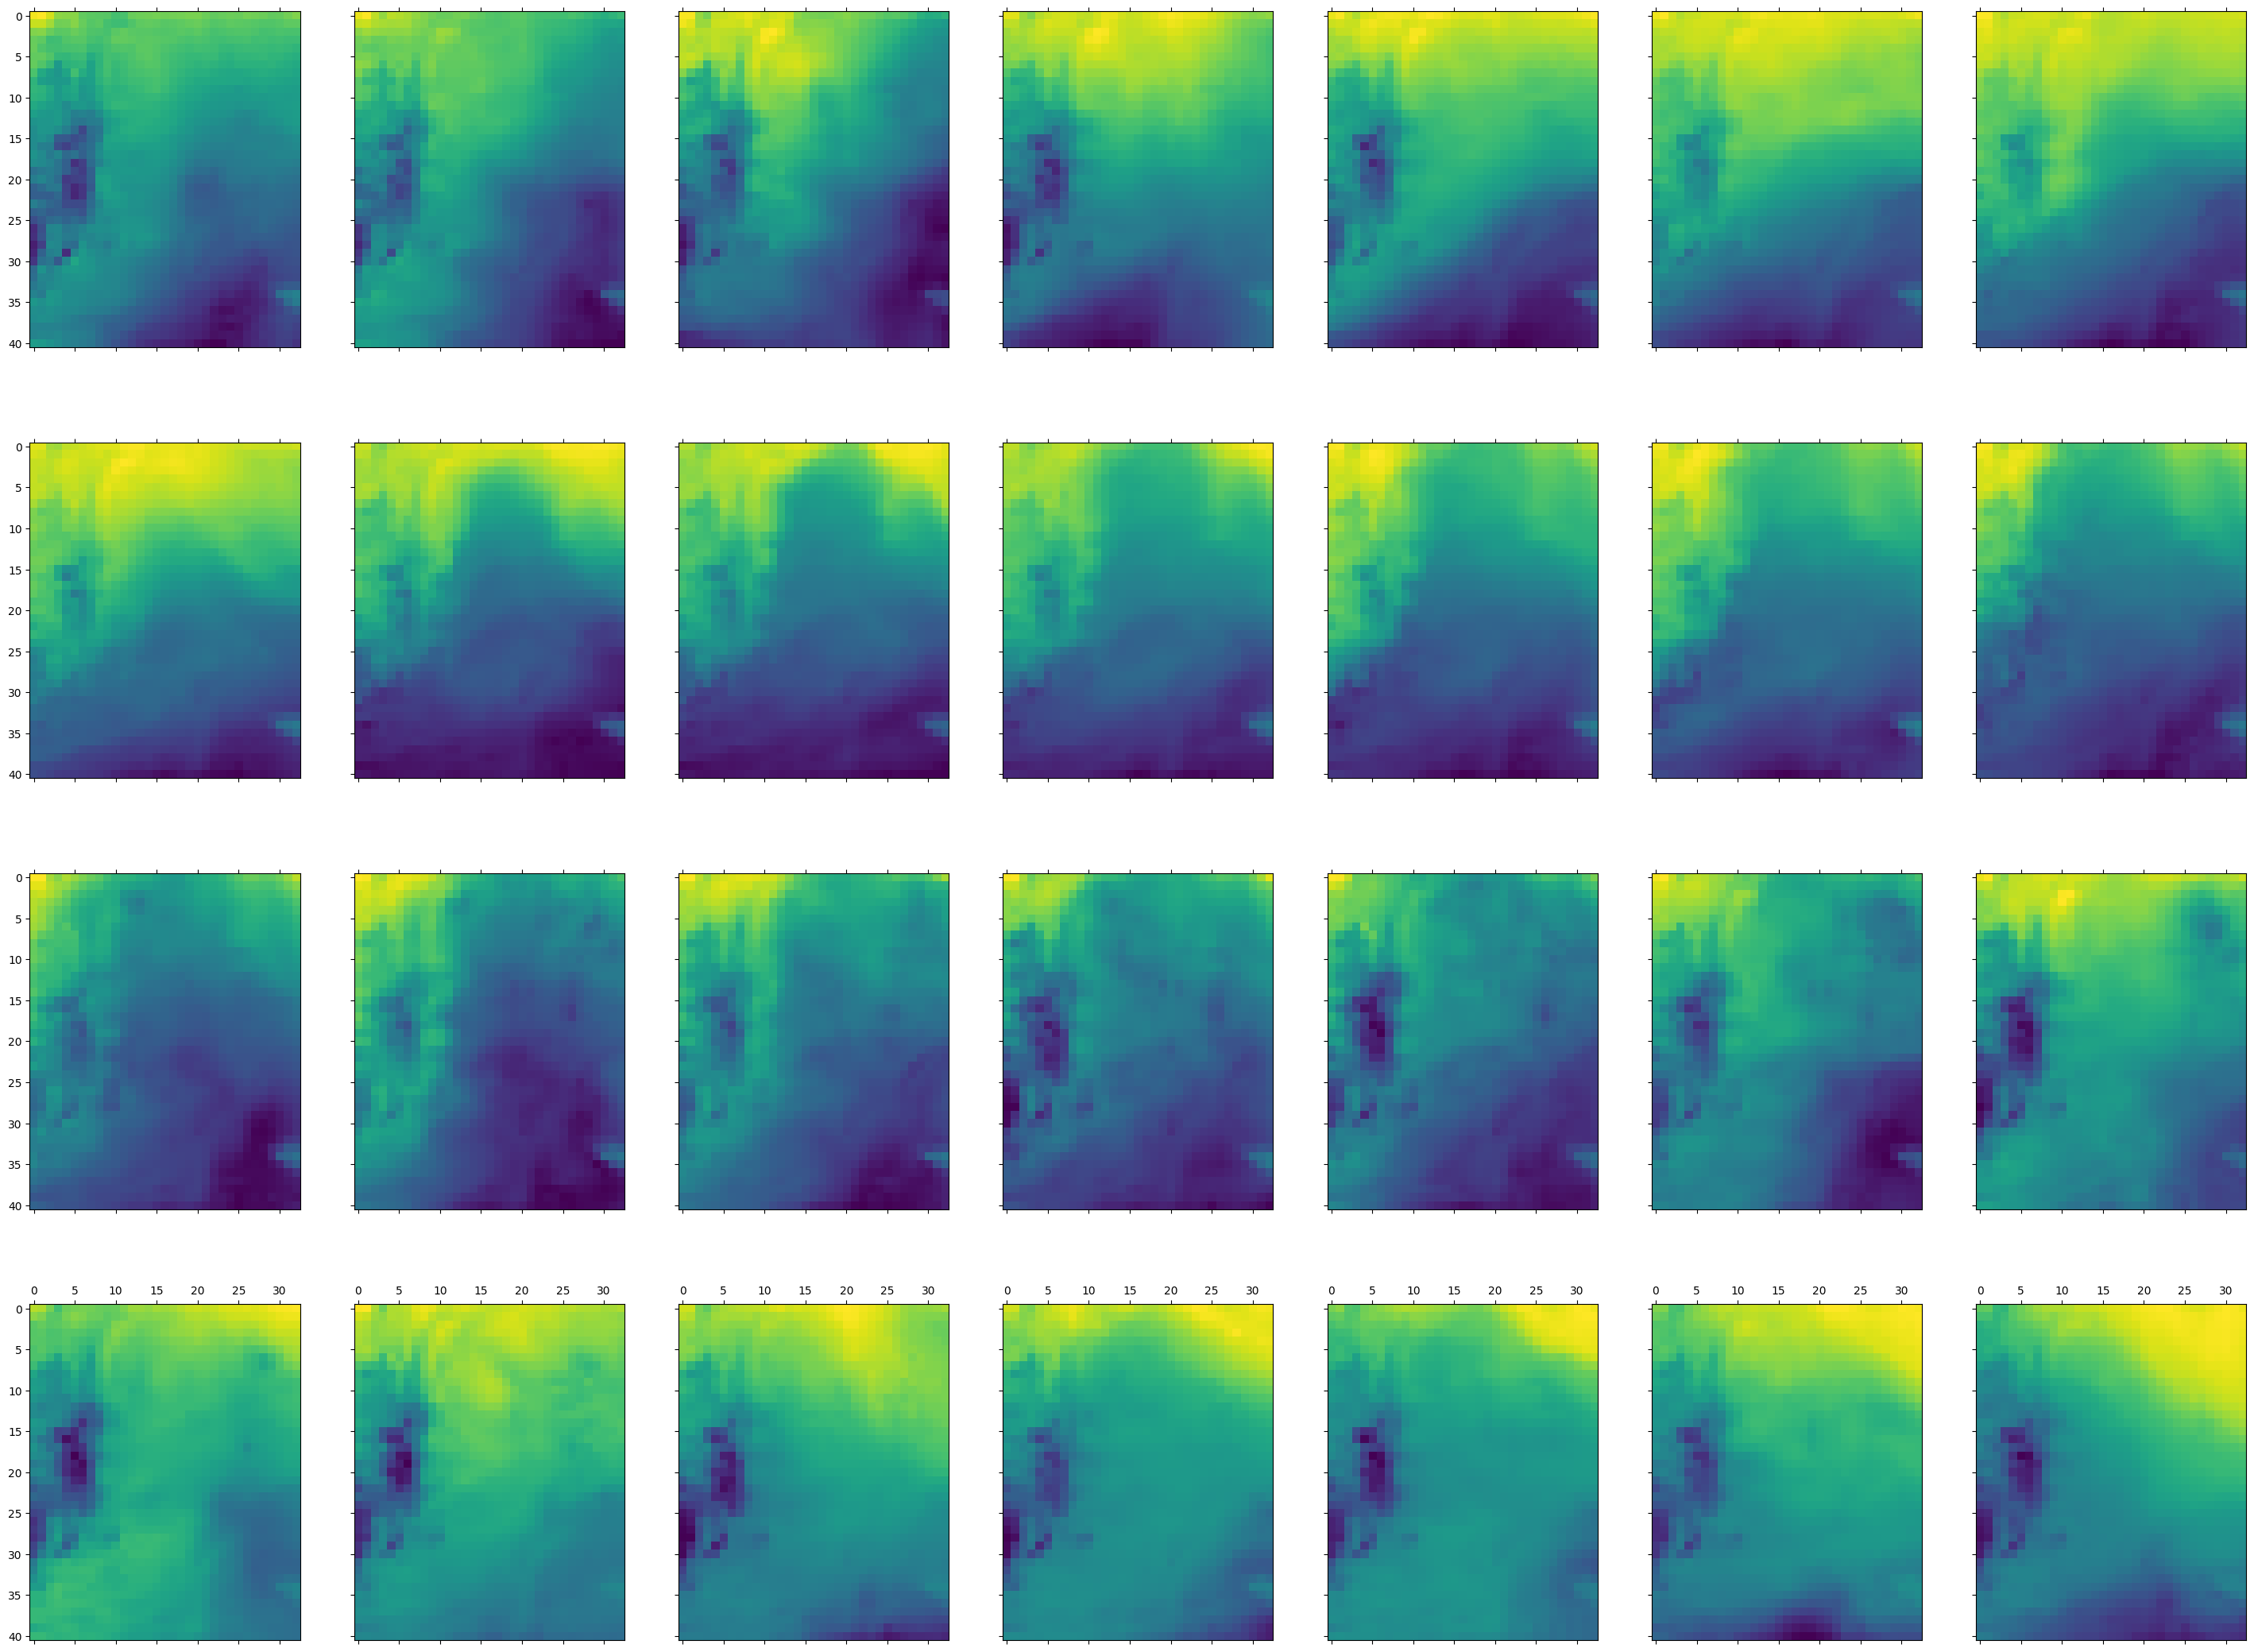

In [ ]:
fig, ax = plt.subplots(4, 7, sharex='col', sharey='row', figsize=(36, 27))
for i in range(0, 4):
    for j in range(0, 7):
        ax[i, j].matshow(np.array(data[i*7 + j,:, :]))

In [ ]:
def removeInnerPoint(ptCld): # input numpy array
    ptCldList = ptCld.tolist()
    removeList = []
    for pt in ptCldList:
        left = [pt[0], pt[1] - 1]
        right = [pt[0], pt[1] + 1]
        top = [pt[0] - 1, pt[1]]
        bottom = [pt[0] + 1, pt[1]]
        if (left in ptCldList) and (right in ptCldList) and (top in ptCldList) and (bottom in ptCldList):
            removeList.append(pt)
    
    for removePt in removeList:
        ptCldList.remove(removePt)
    return np.array(ptCldList)

def shift_filtration(rips,n):
    "Take a Dionysus filtration and increase the name of all of the vertices by n."
    f = d.Filtration()
    for s in rips:
        dim = s.dimension()
        temp = []
        for i in range(0,dim+1):
            temp.append(s[i]+n)
        f.append(d.Simplex(temp,s.data))
    return f

def get_verts(simp):
    if simp.dimension == 2:
        return [d.Simplex([v], 0) for v in t]
    else:
        return set([s for s in simp.boundary()])

def setup_Zigzag_fixed(lst, r, ptCldLengthList):

    simps_list = []
    times_list = []

    # Initialize A with R(X_0)
    rips = d.fill_rips(lst[0].astype(np.float32), 2, r)
    rips.sort()
    rips_set = set(rips)

    # Initialize A with set of simplices with verts in X_0
    A = rips_set

    # # Add all simps to the list with birth,death=[0,1]
    simps_list = simps_list + [s for s in A]
    times_list = times_list + [[0, 1] for j in range(len(A))]

    for i in range(1, len(lst)):

        # Calculate rips of X_{i-1} \cup X_i
        rips = d.fill_rips(np.vstack([lst[i-1], lst[i]]).astype(np.float32), 2, r)
        rips = shift_filtration(rips, ptCldLengthList[i-1])

        # Set of vertices in R(X_i)
        B = d.fill_rips(lst[i].astype(np.float32), 2, r)
        B = shift_filtration(B, ptCldLengthList[i])

        # Set of simplices with verts in X_{i-1} AND X_{i}
        M = set()

        # Loop over vertices in R(X_{i-1} \cup R_i)
        for simp in rips:
            
            # Get list of vertices of simp
            bdy = get_verts(simp)
            #print ('Simplex {} has vertices {}'.format(simp, bdy))
            # If it has no boundary and its in B, its a vertex in B and has been handled
            if not bdy:
                continue

            # If all of its verts are in A, it's been handled in the initialization or the previous iteration
            if bdy.intersection(A) == bdy:
                continue

            # If all of its verts are in B, add it to B
            elif bdy.intersection(B) == bdy:
                #print (simp)
                continue

            # If it has some verts in A and some in B, it only exists in the union
            # Add it to M
            else:
                M.add(simp)
        
        # Add simplices in B with the corresponding birth,death times
        simps_list = simps_list + [s for s in B]
        times_list = times_list + [[i-0.5, i+1] for j in range(len(B))]

        # Add simplicies in M with corresponding birth,death times
        simps_list = simps_list + [s for s in M]
        times_list = times_list + [[i-0.5, i] for j in range(len(M))]

        # Reinitialize for next iteration
        A = B

    filtration = d.Filtration(simps_list)

    #print ('length of time list: {}'.format(len(times_list)))
    #print ('length of simp list: {}'.format(len(simps_list)))
    #print ('length of filtration: {}'.format(len(filtration)))

    return filtration, times_list

In [ ]:
def getZZPDOneLevel(data, heatLevel, r):
    zigzagDataList = []
    for i in range(0, 4): # 4, 7 change later
        for j in range(0, 7):
            pointcloud = np.argwhere(np.array(data[i*7 + j ,: ,:]) < heatLevel)
            newPtCld = removeInnerPoint(pointcloud)
            zigzagDataList.append(newPtCld)
    
    tempPtCldLengthList = []
    for i in zigzagDataList:
        tempPtCldLengthList.append(len(i))
    ptCldLengthList = np.cumsum(tempPtCldLengthList).tolist()
    ptCldLengthList.insert(0, 0)
    ptCldLengthList = np.array(ptCldLengthList)

    filtration, times_list = setup_Zigzag_fixed(zigzagDataList, r, ptCldLengthList)
    zz, dgms, cells = d.zigzag_homology_persistence(filtration, times_list)

    birth0=np.array([dgm.birth for dgm in dgms[0]])
    death0=np.array([dgm.death for dgm in dgms[0]])
    birth1=np.array([dgm.birth for dgm in dgms[1]])
    death1=np.array([dgm.death for dgm in dgms[1]])

    return [[birth0,death0], [birth1,death1]]

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 9))

levelRange = [264, 267, 270, 273, 276, 279]  # change later to general
for i in range(2):
    for j in range(3):
        heatLevel = levelRange[i*3 + j]
        p0, p1 = getZZPDOneLevel(data, heatLevel, 5) # 3 change later
        axs[i, j].scatter(p1[0], p1[1], marker='^', s=5, facecolors='none', edgecolor='blue', label = 'Dimension 1')
        axs[i, j].plot(np.arange(0, 30), np.arange(0, 30), '-', color='grey', lw=0.5)
        print ('In Process: {0:.0%}'.format((i*3+j+1)/6)) 
plt.show()

'''
for i in range(len(levelRange)):
    heatLevel = levelRange[i]
    p0, p1 = getZZPDOneLevel(data, heatLevel, 2) # 3 change later
    axs[i%3, i - 3*(i%3)].scatter(p1[0], p1[1], marker='^', s=5, facecolors='none', edgecolor='blue', label = 'Dimension 1')
    axs[i%3, i - 3*(i%3)].plot(np.arange(0, 30), np.arange(0, 30), '-', color='grey', lw=0.5)

plt.show()
'''

In Process: 17%
In Process: 33%
In Process: 50%
In Process: 67%
In Process: 83%


In [ ]:
heatLevel = 261
r = 2

p0, p1 = getZZPDOneLevel(data, heatLevel, r)
plt.scatter(p1[0], p1[1], marker='^', s=5, facecolors='none', edgecolor='blue', label = 'Dimension 1')
plt.plot(np.arange(0, 30), np.arange(0, 30), '-', color='grey', lw=0.5)
plt.show()

In [ ]:
heatLevel = 264

fig, ax = plt.subplots(4, 7, sharex='col', sharey='row', figsize=(36, 27))
for i in range(0, 4):
    for j in range(0, 7):
        pointcloud = np.argwhere(np.array(data[i*7 + j ,: ,:]) < heatLevel)
        x = pointcloud[:, 1]
        y = 41 - pointcloud[:, 0]
        ax[i, j].scatter(x, y)
        ax[i, j].set_xlim([0, 32])
        ax[i, j].set_ylim([0, 41])
plt.show()

In [ ]:
heatLevel = 264

fig, ax = plt.subplots(4, 7, sharex='col', sharey='row', figsize=(36, 27))

zigzagDataList = []
for i in range(0, 4):
    for j in range(0, 7):
        pointcloud = np.argwhere(np.array(data[i*7 + j ,: ,:]) < heatLevel)
        newPtCld = removeInnerPoint(pointcloud)
        zigzagDataList.append(newPtCld)
        x = newPtCld[:, 1]
        y = 41 - newPtCld[:, 0]
        ax[i, j].scatter(x, y)
        ax[i, j].set_xlim([0, 32])
        ax[i, j].set_ylim([0, 41])

plt.show()

In [ ]:
filtration, times_list = setup_Zigzag_fixed(zigzagDataList, 5)
zz, dgms, cells = d.zigzag_homology_persistence(filtration, times_list)


In [ ]:
#d.plot.plot_diagram(dgms[0], show = True)
d.plot.plot_diagram(dgms[1], show = True)